In [6]:
from datasets import load_dataset

train_dataset = load_dataset("json", data_files="dataset_final_results/stratified_train.json")
val_dataset = load_dataset("json", data_files="dataset_final_results/stratified_val.json")
test_dataset = load_dataset("json", data_files="dataset_final_results/stratified_test.json")

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [7]:
train_dataset

DatasetDict({
    train: Dataset({
        features: ['Dialogue', 'Equipment', 'Result', 'Event', 'Race', 'Location', 'Condition', 'Response_to', 'Line_of_dialogue', 'Speaker', 'Tone'],
        num_rows: 1417
    })
})

In [8]:
val_dataset

DatasetDict({
    train: Dataset({
        features: ['Dialogue', 'Equipment', 'Result', 'Event', 'Race', 'Location', 'Condition', 'Response_to', 'Line_of_dialogue', 'Speaker', 'Tone'],
        num_rows: 175
    })
})

In [9]:
test_dataset

DatasetDict({
    train: Dataset({
        features: ['Dialogue', 'Equipment', 'Result', 'Event', 'Race', 'Location', 'Condition', 'Response_to', 'Line_of_dialogue', 'Speaker', 'Tone'],
        num_rows: 181
    })
})

In [5]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [6]:
def formatting_func(example):


    description = f"""The following text elaborates on what line of dialogue is used by an NPC in a certain event. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed within <EVENT> and </EVENT>, the type of speaker will be enclosed within <SPEAKER> and </SPEAKER> and the line used will be enclosed within <LINE> and </LINE>.

"""
    if example['Event'] == "Greeting":

        description = f"""The following text describes a greeting exchange between the Player and an NPC. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed within <EVENT> and </EVENT>, the type of speaker will be enclosed within <SPEAKER> and </SPEAKER>, the line used will be enclosed within <LINE> and </LINE>, and the tone of the line will be enclosed within <TONE> and </TONE>.

"""
    elif example['Event'] == "NPCs fighting over a Player's dropped item":

        description = f"""The following text describes an exchange where multiple NPCs are fighting over a Player's dropped item and one of them uses a line of dialogue. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed within <EVENT> and </EVENT>, the type of speaker will be enclosed within <SPEAKER> and </SPEAKER>, the line used will be enclosed within <LINE> and </LINE>, and the number of the current spoken line in the dialogue will be enclosed within <NUMBER> and </NUMBER>.

"""
    elif example['Condition'] == "in combat":

        description = f"""The following text elaborates on which line of dialogue a friendly NPC uses when it is in combat. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed within <EVENT> and </EVENT>,the type of speaker will be enclosed within <SPEAKER> and </SPEAKER>, the line used will be enclosed within <LINE> and </LINE>, and  the condition will be enclosed within <CONDITION> and </CONDITION>.

"""
    elif example['Result'] is not None:

        description = f"""The following text text elaborates on which line of dialogue is used by an NPC when the Player character tries to persuade them. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed within <EVENT> and </EVENT>,the type of speaker will be enclosed within <SPEAKER> and </SPEAKER>, the line used will be enclosed within <LINE> and </LINE> and the result of the event will be enclosed within <RESULT> and </RESULT> .

"""
    elif example['Race'] is not None:

        description = f"""The following text describes the reaction of a Guard based on the Player's race. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed within <EVENT> and </EVENT>, the type of speaker will be enclosed within <SPEAKER> and </SPEAKER>, the line used will be enclosed within <LINE> and </LINE>, the race of the Player will be enclosed within <RACE> and </RACE>, and the condition, if there is one, will be enclosed within <CONDITION> and </CONDITION>.

"""
    elif example['Equipment'] is not None:

        description = f"""The following text describes the reaction of a Guard based on the Player's equipment. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed within <EVENT> and </EVENT>, the type of speaker will be enclosed within <SPEAKER> and </SPEAKER>, the line used will be enclosed within <LINE> and </LINE>, the equipment of the Player will be enclosed within <EQUIPMENT> and </EQUIPMENT>, and the condition, if there is one, will be enclosed within <CONDITION> and </CONDITION>.

"""
    elif example['Location'] is not None:

        description = f"""The following text describes a special interaction of a Guard based on the Player's location. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed within <EVENT> and </EVENT>, the type of speaker will be enclosed within <SPEAKER> and </SPEAKER>, the line used will be enclosed within <LINE> and </LINE>, the location of the Player will be enclosed within <LOCATION> and </LOCATION>, and the condition, if there is one, will be enclosed within <CONDITION> and </CONDITION>.

"""

    elif example['Response_to'] is not None:

        description = f"""The following text describes a part of a dialogue between and NPC and the Player in the case of a certain event. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed within <EVENT> and </EVENT>, the type of speaker will be enclosed within <SPEAKER> and </SPEAKER>, the line used will be enclosed within <LINE> and </LINE>, and the line that the speaker responds to, will be enclosed within <RESPONSE> and </RESPONSE>.

"""
    elif example['Condition'] is not None:

        description = f"""The following text elaborates on a line of dialogue used by an NPC in a certain event under a condition. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed within <EVENT> and </EVENT>, the type of speaker will be enclosed within <SPEAKER> and </SPEAKER>, the line used will be enclosed within <LINE> and </LINE>, and the condition, will be enclosed within <CONDITION> and </CONDITION>.

"""


    if example['Speaker'] == "Any":

        npc_type = "the NPC, that is of any type"

    elif "Guard" in example['Speaker']:

        npc_type = f'the {example["Speaker"]}'

    elif "trainer" in example['Event']:

        npc_type = f"""the trainer NPC, that is named {example['Speaker']}"""

    elif example['Speaker'] == "Housecarl":

        npc_type = "the Housecarl"

    else:

        npc_type = f'the NPC, that is the type {example["Speaker"]}'



    if example['Event'] == "Greeting":

        return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of a <EVENT>{example['Event']}</EVENT>, between an NPC and the Player character, <SPEAKER>{npc_type}</SPEAKER> greets the Player, in a <TONE>{example['Tone']}</TONE> tone, using the following line of dialogue: <LINE>{example['Dialogue']}</LINE>.
<END>"""


    if example['Event'] == "Goodbye":

        return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of a <EVENT>{example['Event']}</EVENT>, between an NPC and the Player character,<SPEAKER>{npc_type}</SPEAKER> tells their goodbyes to the Player using the following line of dialogue: <LINE>{example['Dialogue']}</LINE>.
<END>"""


    if example['Event'] == "NPCs fighting over a Player's dropped item":

        return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of <EVENT>{example['Event']}</EVENT>, there can be up to 5 different NPCs arguing over an item that the Player character dropped and up to 2 bystander NPCs commenting on the situation. Up to five lines of dialogue can be exchanged between up to five different NPCs that are arguing and up to two lines of bystander dialogue can be used by up to two different bystander NPCs, meaning that the conversation ends after a maximum of 7 lines of dialogue have been said. In this case one of the NPCs that takes part in the arguing and is <SPEAKER>{npc_type}</SPEAKER>, says, as the <NUMBER>{example['Line_of_dialogue']}</NUMBER> line of the dialogue, the following line: <LINE>{example['Dialogue']}</LINE>.
<END>"""

    if example['Event'] == "NPC asking for the Player's dropped armor":

        if example['Speaker'] == "Player":
            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of an <EVENT>{example['Event']}</EVENT>, there is a conversation between the Player character and an NPC about the Player's dropped item.
In this case in response to the NPC's previous line of dialogue: <RESPONSE>{example['Response_to']}</RESPONSE>,the <SPEAKER>Player</SPEAKER> character uses the following line of dialogue: <LINE>{example['Dialogue']}</LINE>.
<END>"""

        if example['Response_to'] is not None:

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of an <EVENT>{example['Event']}</EVENT> there is a conversation between the Player character and an NPC about the Player's dropped item.
In this case in response to the Player character's previous line of dialogue: <RESPONSE>{example['Response_to']}</RESPONSE>, <SPEAKER>{npc_type}</SPEAKER> uses the following line of dialogue: <LINE>{example['Dialogue']}</LINE>.
<END>"""
        else:

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of an <EVENT>{example['Event']}</EVENT> there is a conversation between the Player character and an NPC about the Player's dropped item.
In this case to initiate a conversation about the Player's dropped item, <SPEAKER>{npc_type}</SPEAKER> uses the following line of dialogue: <LINE>{example['Dialogue']}</LINE>.
<END>"""

    if example['Condition'] == "in combat":

        return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, when the Player character and a friendly NPC are <CONDITION>{example['Condition']}</CONDITION>, when <EVENT>{example['Event']}</EVENT>,<SPEAKER>{npc_type}</SPEAKER> uses the following line of dialogue: <LINE>{example['Dialogue']}</LINE>.
<END>"""

    if example['Result'] is not None:

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, when the Player character tries to check if an NPC of any type can be persuaded, when <EVENT>{example['Event']}</EVENT> and as a result </RESULT>{example['Result']}<RESULT>, the <SPEAKER>{npc_type}</SPEAKER> uses the following line of dialogue: <LINE>{example['Dialogue']}</LINE>.
<END>"""

    if example['Event'] == "an NPC spots the Player character having an amulet of mara":

        if example['Speaker'] == "Player":

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, when <EVENT>{example['Event']}</EVENT> an interaction begins between the two about the possibility of marriage.
In this case in response to the the NPC's previous dialogue line: <RESPONSE>{example['Response_to']}</RESPONSE>, the <SPEAKER>Player</SPEAKER> character uses the following line of dialogue: <LINE>{example['Dialogue']}</LINE>.
<END>"""

        if example['Response_to'] is None:

            return description +  f"""<START>
In the world of Skyrim from the game Elder Scrolls V, when <EVENT>{example['Event']}</EVENT> an interaction begins between the two about the possibility of marriage.
In this case to initiate the conversation about marriage, <SPEAKER>{npc_type}</SPEAKER> uses the following line of dialogue: <LINE>{example['Dialogue']}</LINE>.
<END>"""

        else:

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, when <EVENT>{example['Event']}</EVENT> an interaction begins between the two about the possibility of marriage.
In this case in response to the the Player's previous dialogue line: <RESPONSE>{example['Response_to']}</RESPONSE>, <SPEAKER>{npc_type}</SPEAKER> uses the following line of dialogue: <LINE>{example['Dialogue']}</LINE>.
<END>"""

    if example['Race'] is not None:

        if example['Condition'] is not None:

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, Town Guards have special reactions to the race of the Player character, in the case of <EVENT>{example['Event']}</EVENT>, if the Player's race is <RACE>{example['Race']}</RACE> and <CONDITION>{example['Condition']}</CONDITION>, the <SPEAKER>Guard</SPEAKER> uses the following line of dialogue: <LINE>{example['Dialogue']}</LINE>.
<END>"""

        else:

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, Town Guards have special reactions to the race of the Player character, so in the case of <EVENT>{example['Event']}</EVENT>, if the Player's race is <RACE>{example['Race']}</RACE>, the <SPEAKER>Guard</SPEAKER> uses the following line of dialogue: <LINE>{example['Dialogue']}</LINE>.
<END>"""

    if example['Equipment'] is not None:

        if example['Condition'] is not None:

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, Town Guards have special reactions to the equipment the Player character is holding or has equipped, so when in the case of a <EVENT>{example['Event']}</EVENT> and <CONDITION>{example['Condition']}</CONDITION>, to react to the Player's <EQUIPMENT>{example['Equipment']}</EQUIPMENT>, the <SPEAKER>Guard</SPEAKER> uses the following line of dialogue: <LINE>{example['Dialogue']}</LINE>.
<END>"""

        else:

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, Town Guards have special reactions to the equipment the Player character is holding or has equipped, so when in the case of a <EVENT>{example['Event']}</EVENT>, to react to the Player's <EQUIPMENT>{example['Equipment']}</EQUIPMENT>, the <SPEAKER>Guard</SPEAKER> uses the following line of dialogue: <LINE>{example['Dialogue']}</LINE>.
<END>"""

    if example['Location'] is not None:

        if example['Condition'] is not None:

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, <EVENT>Town Guards have special interactions with the Player character that are location based</EVENT>, meaning that the Guards sometimes interact with the Player using town specific dialogue.
In this case in the town of <LOCATION>{example['Location']}</LOCATION> and on the condition that <CONDITION>{example['Condition']}</CONDITION>, a <SPEAKER>Guard</SPEAKER>, when the Player character interacts with them, uses the following line of dialogue: <LINE>{example['Dialogue']}</LINE>.
<END>"""

        else:

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, <EVENT>Town Guards have special interactions with the Player character that are location based</EVENT>, meaning that the Guards sometimes interact with the Player using town specific dialogue.
In this case in the town of <LOCATION>{example['Location']}</LOCATION>, a <SPEAKER>Guard</SPEAKER>, when the Player character interacts with them, uses the following line of dialogue: <LINE>{example['Dialogue']}</LINE>.
<END>"""

    if example['Condition'] is not None:

          return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of <EVENT>{example['Event']}</EVENT> and on the condition that <CONDITION>{example['Condition']}</CONDITION>, <SPEAKER>{npc_type}</SPEAKER>, says the following line to the Player character: <LINE>{example['Dialogue']}</LINE>.
<END>"""

    return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of <EVENT>{example['Event']}</EVENT>, <SPEAKER>{npc_type}</SPEAKER>, says the following line to the Player character: <LINE>{example['Dialogue']}</LINE>.
<END>"""

In [7]:
# Explicitly setting the token
import os
os.environ["HF_TOKEN"] = ""

In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, AutoConfig
config = AutoConfig.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")

In [9]:
base_model_id = "mistralai/Mistral-7B-Instruct-v0.2"

In [10]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [11]:
model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config,config=config)

tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token


`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [12]:
def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

In [13]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)

In [14]:
tokenized_val_dataset = val_dataset.map(generate_and_tokenize_prompt)

1592


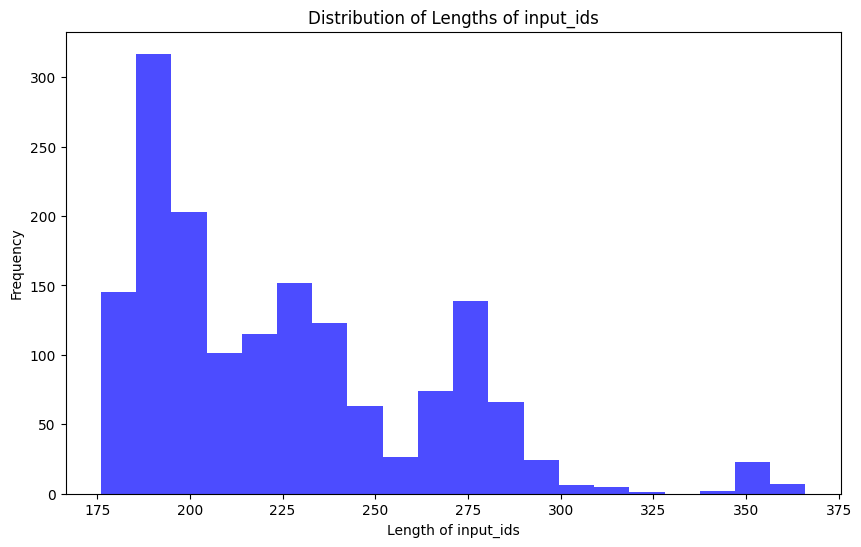

In [15]:
import matplotlib.pyplot as plt


def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset['train']]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset['train']]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [16]:
import numpy as np

lengths = [len(x['input_ids']) for x in tokenized_train_dataset['train']]

print(f"Mean: {np.mean(lengths)}")

# Calculate the 95th percentile
print(f"95th percentile: {np.percentile(lengths, 95)}")

# Calculate the max length
print(f"Max length: {np.max(lengths)}")

Mean: 225.57163020465774
95th percentile: 288.0
Max length: 366


In [17]:
max_length = 366  # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [18]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = val_dataset.map(generate_and_tokenize_prompt2)

1592


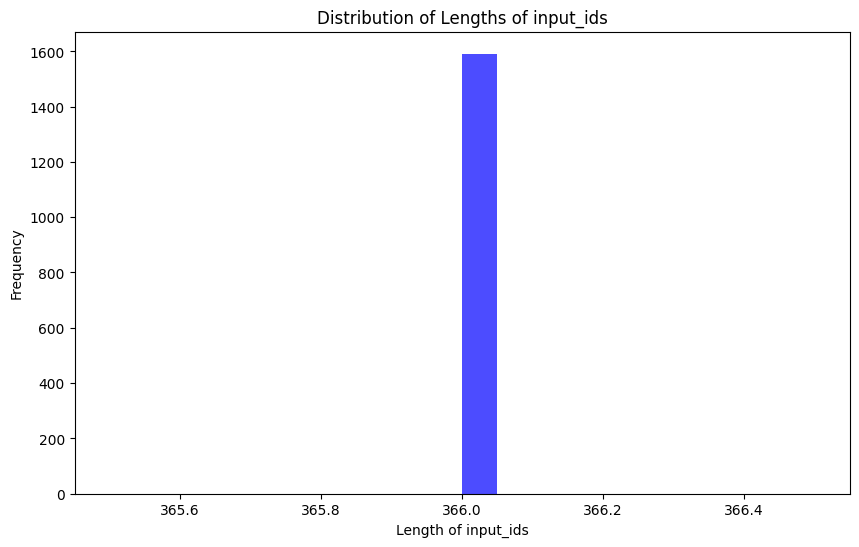

In [19]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [54]:
eval_prompt = (f"""The following text describes a greeting exchange between the Player and an NPC. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed within <EVENT> and </EVENT>, the type of speaker will be enclosed within <SPEAKER> and </SPEAKER>, the line used will be enclosed within <LINE> and </LINE>, and the tone of the line will be enclosed within <TONE> and </TONE>. Please fill in the missing dialogue within the <LINE> and </LINE> tags.

<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of a <EVENT>Greeting</EVENT>, between an NPC and the Player character, <SPEAKER>FemaleCoward</SPEAKER> greets the Player, in a <TONE>Friendly</TONE> tone, with the following line of dialogue: <LINE> </LINE>.
<END>
""")

In [55]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=321, repetition_penalty=1.15)[0],
                                skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


The following text describes a greeting exchange between the Player and an NPC. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed within <EVENT> and </EVENT>, the type of speaker will be enclosed within <SPEAKER> and </SPEAKER>, the line used will be enclosed within <LINE> and </LINE>, and the tone of the line will be enclosed within <TONE> and </TONE>. Please fill in the missing dialogue within the <LINE> and </LINE> tags.

<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of a <EVENT>Greeting</EVENT>, between an NPC and the Player character, <SPEAKER>FemaleCoward</SPEAKER> greets the Player, in a <TONE>Friendly</TONE> tone, with the following line of dialogue: <LINE> </LINE>.
<END>
<LINE>"Hello there, traveler! I hope you're having a good day."</LINE>


In [20]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [21]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [22]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

In [23]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=64,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj,"
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    use_rslora=True,
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 130023424 || all params: 3882094592 || trainable%: 3.3493110721192854


In [24]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer):

In [25]:
if torch.cuda.device_count() > 1:  # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [26]:
model = accelerator.prepare_model(model)

In [28]:
import transformers

project = "NPC-finetune3"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset["train"],
    eval_dataset=tokenized_val_dataset["train"],
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=1417,
        learning_rate=3.5e-7,  # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,  # When to start reporting loss
        logging_dir="./logs",  # Directory for storing logs
        save_strategy="steps",  # Save the model checkpoint every logging step
        save_steps=50,  # Save checkpoints every 50 steps
        evaluation_strategy="steps",  # Evaluate the model every logging step
        eval_steps=50,  # Evaluate and save checkpoints every 50 steps
        do_eval=True,
        max_grad_norm= 1.0 # Gradient clipping
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

C:\Users\Pumukl\AppData\Local\Programs\Python\Python312\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
C:\Users\Pumukl\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two va

Step,Training Loss,Validation Loss
50,0.302600,0.383197


Step,Training Loss,Validation Loss
50,0.302600,0.383197
100,0.286900,0.364442


Step,Training Loss,Validation Loss
50,0.302600,0.383197
100,0.286900,0.364442
150,0.280700,0.343348


Step,Training Loss,Validation Loss
50,0.302600,0.383197
100,0.286900,0.364442
150,0.280700,0.343348
200,0.318600,0.324360


Step,Training Loss,Validation Loss
50,0.302600,0.383197
100,0.286900,0.364442
150,0.280700,0.343348
200,0.318600,0.324360
250,0.288100,0.308441


Step,Training Loss,Validation Loss
50,0.302600,0.383197
100,0.286900,0.364442
150,0.280700,0.343348
200,0.318600,0.324360
250,0.288100,0.308441
300,0.278400,0.294912


Step,Training Loss,Validation Loss
50,0.302600,0.383197
100,0.286900,0.364442
150,0.280700,0.343348
200,0.318600,0.324360
250,0.288100,0.308441
300,0.278400,0.294912
350,0.265000,0.287439


Step,Training Loss,Validation Loss
50,0.302600,0.383197
100,0.286900,0.364442
150,0.280700,0.343348
200,0.318600,0.324360
250,0.288100,0.308441
300,0.278400,0.294912
350,0.265000,0.287439
400,0.244600,0.277900


Step,Training Loss,Validation Loss
50,0.302600,0.383197
100,0.286900,0.364442
150,0.280700,0.343348
200,0.318600,0.324360
250,0.288100,0.308441
300,0.278400,0.294912
350,0.265000,0.287439
400,0.244600,0.277900
450,0.251200,0.265000


Step,Training Loss,Validation Loss
50,0.302600,0.383197
100,0.286900,0.364442
150,0.280700,0.343348
200,0.318600,0.324360
250,0.288100,0.308441
300,0.278400,0.294912
350,0.265000,0.287439
400,0.244600,0.277900
450,0.251200,0.265000
500,0.224800,0.258963


Step,Training Loss,Validation Loss
50,0.302600,0.383197
100,0.286900,0.364442
150,0.280700,0.343348
200,0.318600,0.324360
250,0.288100,0.308441
300,0.278400,0.294912
350,0.265000,0.287439
400,0.244600,0.277900
450,0.251200,0.265000
500,0.224800,0.258963


Step,Training Loss,Validation Loss
50,0.302600,0.383197
100,0.286900,0.364442
150,0.280700,0.343348
200,0.318600,0.324360
250,0.288100,0.308441
300,0.278400,0.294912
350,0.265000,0.287439
400,0.244600,0.277900
450,0.251200,0.265000
500,0.224800,0.258963


Step,Training Loss,Validation Loss
50,0.302600,0.383197
100,0.286900,0.364442
150,0.280700,0.343348
200,0.318600,0.324360
250,0.288100,0.308441
300,0.278400,0.294912
350,0.265000,0.287439
400,0.244600,0.277900
450,0.251200,0.265000
500,0.224800,0.258963


Step,Training Loss,Validation Loss
50,0.302600,0.383197
100,0.286900,0.364442
150,0.280700,0.343348
200,0.318600,0.324360
250,0.288100,0.308441
300,0.278400,0.294912
350,0.265000,0.287439
400,0.244600,0.277900
450,0.251200,0.265000
500,0.224800,0.258963


Step,Training Loss,Validation Loss
50,0.302600,0.383197
100,0.286900,0.364442
150,0.280700,0.343348
200,0.318600,0.324360
250,0.288100,0.308441
300,0.278400,0.294912
350,0.265000,0.287439
400,0.244600,0.277900
450,0.251200,0.265000
500,0.224800,0.258963


Step,Training Loss,Validation Loss
50,0.302600,0.383197
100,0.286900,0.364442
150,0.280700,0.343348
200,0.318600,0.324360
250,0.288100,0.308441
300,0.278400,0.294912
350,0.265000,0.287439
400,0.244600,0.277900
450,0.251200,0.265000
500,0.224800,0.258963


Step,Training Loss,Validation Loss
50,0.302600,0.383197
100,0.286900,0.364442
150,0.280700,0.343348
200,0.318600,0.324360
250,0.288100,0.308441
300,0.278400,0.294912
350,0.265000,0.287439
400,0.244600,0.277900
450,0.251200,0.265000
500,0.224800,0.258963


Step,Training Loss,Validation Loss
50,0.302600,0.383197
100,0.286900,0.364442
150,0.280700,0.343348
200,0.318600,0.324360
250,0.288100,0.308441
300,0.278400,0.294912
350,0.265000,0.287439
400,0.244600,0.277900
450,0.251200,0.265000
500,0.224800,0.258963


KeyboardInterrupt: 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load from the output_dir the last checkpoints trainer state, validation loss and training loss
df = pd.read_json(output_dir + "/checkpoint-800/trainer_state.json")

df = df['log_history']

#drop every third row
df = df.drop(df.index[::3])

df.reset_index(drop=True, inplace=True)
# conbine the dictionaries of every two rows
df = pd.DataFrame([{**df[i], **df[i + 1]} for i in range(0, len(df), 2)])

# keep only the step, training loss and validation loss columns
df = df[['step', 'loss', 'eval_loss']]

df

,step,loss,eval_loss
0,50,0.3026,0.383197
1,100,0.2869,0.364442
2,150,0.2807,0.343348
3,200,0.3186,0.324360
4,250,0.2881,0.308441
5,300,0.2784,0.294912
6,350,0.2650,0.287439
7,400,0.2446,0.277900
8,450,0.2512,0.265000
9,500,0.2248,0.258963


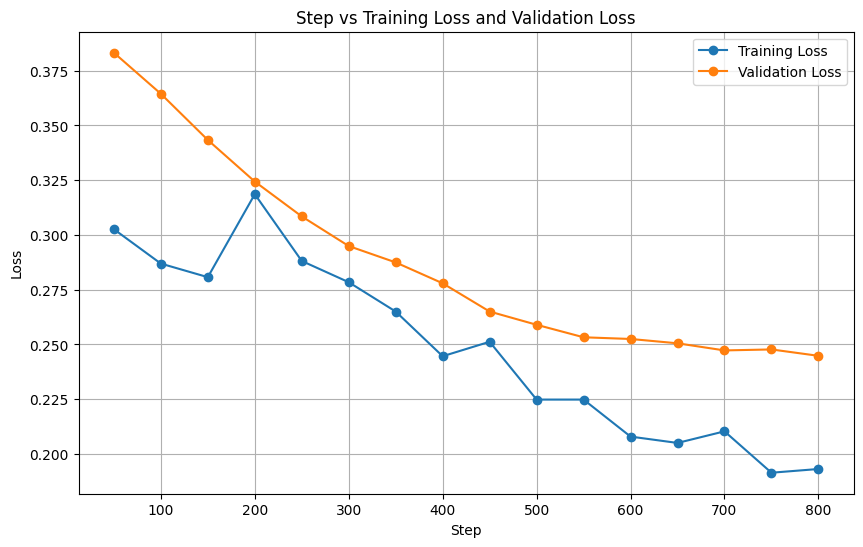

In [2]:
# Plotting the data with updated labels
plt.figure(figsize=(10, 6))
plt.plot(df["step"], df["loss"], marker='o', label="Training Loss")
plt.plot(df["step"], df["eval_loss"], marker='o', label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Step vs Training Loss and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-Instruct-v0.2"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "mistral-NPC-finetune3/checkpoint-700")

In [30]:
eval_prompt = (f"""
The following text elaborates on what line of dialogue is used by an NPC in a certain event. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed within <EVENT> and </EVENT>, the type of speaker will be enclosed within <SPEAKER> and </SPEAKER> and the line used will be enclosed within <LINE> and </LINE>. Generate the missing dialogue line between the <LINE> and </LINE> tags inside the provided text.
    
Please remember to generate the dialogue inside the following <LINE> and </LINE> tags inside the provided text below,for example replace <LINE> </LINE> with <LINE> Missing Dialogue</LINE>.
    
<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of <EVENT>a Guard reacting to the Player's high skill level in Alchemy</EVENT>, <SPEAKER>the Guard</SPEAKER>, says the following line to the Player character : <LINE> </LINE>.
<END>

Answer:
"""
)
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=750, repetition_penalty=1.25)[0],
                                skip_special_tokens=True))
    #save the results to a list
    answer = eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=750, repetition_penalty=1.15)[0],
                                skip_special_tokens=True)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



The following text elaborates on what line of dialogue is used by an NPC in a certain event. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed within <EVENT> and </EVENT>, the type of speaker will be enclosed within <SPEAKER> and </SPEAKER> and the line used will be enclosed within <LINE> and </LINE>. Generate the missing dialogue line between the <LINE> and </LINE> tags inside the provided text.
    
Please remember to generate the dialogue inside the following <LINE> and </LINE> tags inside the provided text below,for example replace <LINE> </LINE> with <LINE> Missing Dialogue</LINE>.
    
<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of <EVENT>a Guard reacting to the Player's high skill level in Alchemy</EVENT>, <SPEAKER>the Guard</SPEAKER>, says the following line to the Player character : <LINE> </LINE>.
<END>

Answer:
<START>
In the world of Skyrim from the game Elder 

In [25]:
import re

matches = re.findall(r'<LINE>(.*?)</LINE>', answer)
print(matches[3])

I'm glad you're here.


In [15]:
def evaluation_func(example):

    description = f"""The following text elaborates on what line of dialogue is used by an NPC in a certain event. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed within <EVENT> and </EVENT>, the type of speaker will be enclosed within <SPEAKER> and </SPEAKER> and the line used will be enclosed within <LINE> and </LINE>. Generate the missing dialogue line between the <LINE> and </LINE> tags inside the provided text.
    
    Please remember to generate the dialogue inside the following <LINE> and </LINE> tags inside the provided text below,for example replace <LINE> </LINE> with <LINE>Missing Dialogue</LINE>
    
"""
    if example['Event'] == "Greeting":

        description = f"""The following text describes a greeting exchange between the Player and an NPC. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed within <EVENT> and </EVENT>, the type of speaker will be enclosed within <SPEAKER> and </SPEAKER>, the line used will be enclosed within <LINE> and </LINE>, and the tone of the line will be enclosed within <TONE> and </TONE>.Generate the missing dialogue line between the <LINE> and </LINE> tags inside the provided text.
        
        Please remember to generate the dialogue inside the following <LINE> and </LINE> tags inside the provided text below,for example replace <LINE> </LINE> with <LINE>Missing Dialogue</LINE>

"""
    elif example['Event'] == "NPCs fighting over a Player's dropped item":

        description = f"""The following text describes an exchange where multiple NPCs are fighting over a Player's dropped item and one of them uses a line of dialogue. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed within <EVENT> and </EVENT>, the type of speaker will be enclosed within <SPEAKER> and </SPEAKER>, the line used will be enclosed within <LINE> and </LINE>, and the number of the current spoken line in the dialogue will be enclosed within <NUMBER> and </NUMBER>. Generate the missing dialogue line between the <LINE> and </LINE> tags inside the provided text.
        
        Please remember to generate the dialogue inside the following <LINE> and </LINE> tags inside the provided text below,for example replace <LINE> </LINE> with <LINE>Missing Dialogue</LINE>

"""
    elif example['Condition'] == "in combat":

        description = f"""The following text elaborates on which line of dialogue a friendly NPC uses when it is in combat. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed within <EVENT> and </EVENT>,the type of speaker will be enclosed within <SPEAKER> and </SPEAKER>, the line used will be enclosed within <LINE> and </LINE>, and  the condition will be enclosed within <CONDITION> and </CONDITION>. Generate the missing dialogue line between the <LINE> and </LINE> tags. Generate the missing dialogue line between the <LINE> and </LINE> tags inside the provided text.
        
        Please remember to generate the dialogue inside the following <LINE> and </LINE> tags inside the provided text below,for example replace <LINE> </LINE> with <LINE>Missing Dialogue</LINE>

"""
    elif example['Result'] is not None:

        description = f"""The following text text elaborates on which line of dialogue is used by an NPC when the Player character tries to persuade them. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed within <EVENT> and </EVENT>,the type of speaker will be enclosed within <SPEAKER> and </SPEAKER>, the line used will be enclosed within <LINE> and </LINE> and the result of the event will be enclosed within <RESULT> and </RESULT>. Generate the missing dialogue line between the <LINE> and </LINE> tags inside the provided text.
        
        Please remember to generate the dialogue inside the following <LINE> and </LINE> tags inside the provided text below,for example replace <LINE> </LINE> with <LINE>Missing Dialogue</LINE>

"""
    elif example['Race'] is not None:

        description = f"""The following text describes the reaction of a Guard based on the Player's race. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed within <EVENT> and </EVENT>, the type of speaker will be enclosed within <SPEAKER> and </SPEAKER>, the line used will be enclosed within <LINE> and </LINE>, the race of the Player will be enclosed within <RACE> and </RACE>, and the condition, if there is one, will be enclosed within <CONDITION> and </CONDITION>. Generate the missing dialogue line between the <LINE> and </LINE> tags inside the provided text.
        
        Please remember to generate the dialogue inside the following <LINE> and </LINE> tags inside the provided text below,for example replace <LINE> </LINE> with <LINE>Missing Dialogue</LINE>

"""
    elif example['Equipment'] is not None:

        description = f"""The following text describes the reaction of a Guard based on the Player's equipment. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed within <EVENT> and </EVENT>, the type of speaker will be enclosed within <SPEAKER> and </SPEAKER>, the line used will be enclosed within <LINE> and </LINE>, the equipment of the Player will be enclosed within <EQUIPMENT> and </EQUIPMENT>, and the condition, if there is one, will be enclosed within <CONDITION> and </CONDITION>. Generate the missing dialogue line between the <LINE> and </LINE> tags inside the provided text.
        
        Please remember to generate the dialogue inside the following <LINE> and </LINE> tags inside the provided text below,for example replace <LINE> </LINE> with <LINE>Missing Dialogue</LINE>w.

"""
    elif example['Location'] is not None:

        description = f"""The following text describes a special interaction of a Guard based on the Player's location. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed within <EVENT> and </EVENT>, the type of speaker will be enclosed within <SPEAKER> and </SPEAKER>, the line used will be enclosed within <LINE> and </LINE>, the location of the Player will be enclosed within <LOCATION> and </LOCATION>, and the condition, if there is one, will be enclosed within <CONDITION> and </CONDITION>. Generate the missing dialogue line between the <LINE> and </LINE> tags inside the provided text.
        
        Please remember to generate the dialogue inside the following <LINE> and </LINE> tags inside the provided text below,for example replace <LINE> </LINE> with <LINE>Missing Dialogue</LINE>

"""

    elif example['Response_to'] is not None:

        description = f"""The following text describes a part of a dialogue between and NPC and the Player in the case of a certain event. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed within <EVENT> and </EVENT>, the type of speaker will be enclosed within <SPEAKER> and </SPEAKER>, the line used will be enclosed within <LINE> and </LINE>, and the line that the speaker responds to, will be enclosed within <RESPONSE> and </RESPONSE>. Generate the missing dialogue line between the <LINE> and </LINE> tags inside the provided text.
        
        Please remember to generate the dialogue inside the following <LINE> and </LINE> tags inside the provided text below,for example replace <LINE> </LINE> with <LINE>Missing Dialogue</LINE>

"""
    elif example['Condition'] is not None:

        description = f"""The following text elaborates on a line of dialogue used by an NPC in a certain event under a condition. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed within <EVENT> and </EVENT>, the type of speaker will be enclosed within <SPEAKER> and </SPEAKER>, the line used will be enclosed within <LINE> and </LINE>, and the condition, will be enclosed within <CONDITION> and </CONDITION>. Generate the missing dialogue line between the <LINE> and </LINE> tags inside the provided text.
        
        Please remember to generate the dialogue inside the following <LINE> and </LINE> tags inside the provided text below,for example replace <LINE> </LINE> with <LINE>Missing Dialogue</LINE>
        
"""


    if example['Speaker'] == "Any":

        npc_type = "the NPC, that is of any type"

    elif "Guard" in example['Speaker']:

        npc_type = f'the {example["Speaker"]}'

    elif "trainer" in example['Event']:

        npc_type = f"""the trainer NPC, that is named {example['Speaker']}"""

    elif example['Speaker'] == "Housecarl":

        npc_type = "the Housecarl"

    else:

        npc_type = f'the NPC, that is the type {example["Speaker"]}'



    if example['Event'] == "Greeting":

        return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of a <EVENT>{example['Event']}</EVENT>, between an NPC and the Player character, <SPEAKER>{npc_type}</SPEAKER> greets the Player, in a <TONE>{example['Tone']}</TONE> tone, using the following line of dialogue: <LINE> </LINE>.
<END>

Answer:
"""


    if example['Event'] == "Goodbye":

        return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of a <EVENT>{example['Event']}</EVENT>, between an NPC and the Player character,<SPEAKER>{npc_type}</SPEAKER> tells their goodbyes to the Player using the following line of dialogue: <LINE> </LINE>.
<END>

Answer:
"""


    if example['Event'] == "NPCs fighting over a Player's dropped item":

        return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of <EVENT>{example['Event']}</EVENT>, there can be up to 5 different NPCs arguing over an item that the Player character dropped and up to 2 bystander NPCs commenting on the situation. Up to five lines of dialogue can be exchanged between up to five different NPCs that are arguing and up to two lines of bystander dialogue can be used by up to two different bystander NPCs, meaning that the conversation ends after a maximum of 7 lines of dialogue have been said. In this case one of the NPCs that takes part in the arguing and is <SPEAKER>{npc_type}</SPEAKER>, says, as the <NUMBER>{example['Line_of_dialogue']}</NUMBER> line of the dialogue, the following line: <LINE> </LINE>.
<END>

Answer:
"""

    if example['Event'] == "NPC asking for the Player's dropped armor":

        if example['Speaker'] == "Player":
            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of an <EVENT>{example['Event']}</EVENT>, there is a conversation between the Player character and an NPC about the Player's dropped item.
In this case in response to the NPC's previous line of dialogue: <RESPONSE>{example['Response_to']}</RESPONSE>,the <SPEAKER>Player</SPEAKER> character uses the following line of dialogue: <LINE> </LINE>.
<END>

Answer:
"""

        if example['Response_to'] is not None:

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of an <EVENT>{example['Event']}</EVENT> there is a conversation between the Player character and an NPC about the Player's dropped item.
In this case in response to the Player character's previous line of dialogue: <RESPONSE>{example['Response_to']}</RESPONSE>, <SPEAKER>{npc_type}</SPEAKER> uses the following line of dialogue: <LINE> </LINE>.
<END>

Answer:
"""

        else:

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of an <EVENT>{example['Event']}</EVENT> there is a conversation between the Player character and an NPC about the Player's dropped item.
In this case to initiate a conversation about the Player's dropped item, <SPEAKER>{npc_type}</SPEAKER> uses the following line of dialogue: <LINE></LINE>.
<END>

Answer:
"""

    if example['Condition'] == "in combat":

        return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, when the Player character and a friendly NPC are <CONDITION>{example['Condition']}</CONDITION>, when <EVENT>{example['Event']}</EVENT>,<SPEAKER>{npc_type}</SPEAKER> uses the following line of dialogue: <LINE> </LINE>.
<END>

Answer:
"""

    if example['Result'] is not None:

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, when the Player character tries to check if an NPC of any type can be persuaded, when <EVENT>{example['Event']}</EVENT> and as a result </RESULT>{example['Result']}<RESULT>, the <SPEAKER>{npc_type}</SPEAKER> uses the following line of dialogue: <LINE> </LINE>.
<END>

Answer:
"""

    if example['Event'] == "an NPC spots the Player character having an amulet of mara":

        if example['Speaker'] == "Player":

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, when <EVENT>{example['Event']}</EVENT> an interaction begins between the two about the possibility of marriage.
In this case in response to the the NPC's previous dialogue line: <RESPONSE>{example['Response_to']}</RESPONSE>, the <SPEAKER>Player</SPEAKER> character uses the following line of dialogue: <LINE> </LINE>.
<END>

Answer:
"""

        if example['Response_to'] is None:

            return description +  f"""<START>
In the world of Skyrim from the game Elder Scrolls V, when <EVENT>{example['Event']}</EVENT> an interaction begins between the two about the possibility of marriage.
In this case to initiate the conversation about marriage, <SPEAKER>{npc_type}</SPEAKER> uses the following line of dialogue: <LINE> </LINE>.
<END>

Answer:
"""

        else:

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, when <EVENT>{example['Event']}</EVENT> an interaction begins between the two about the possibility of marriage.
In this case in response to the the Player's previous dialogue line: <RESPONSE>{example['Response_to']}</RESPONSE>, <SPEAKER>{npc_type}</SPEAKER> uses the following line of dialogue: <LINE> </LINE>.
<END>

Answer:
"""

    if example['Race'] is not None:

        if example['Condition'] is not None:

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, Town Guards have special reactions to the race of the Player character, in the case of <EVENT>{example['Event']}</EVENT>, if the Player's race is <RACE>{example['Race']}</RACE> and <CONDITION>{example['Condition']}</CONDITION>, the <SPEAKER>Guard</SPEAKER> uses the following line of dialogue: <LINE> </LINE>.
<END>

Answer:
"""

        else:

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, Town Guards have special reactions to the race of the Player character, so in the case of <EVENT>{example['Event']}</EVENT>, if the Player's race is <RACE>{example['Race']}</RACE>, the <SPEAKER>Guard</SPEAKER> uses the following line of dialogue: <LINE> </LINE>.
<END>

Answer:
"""

    if example['Equipment'] is not None:

        if example['Condition'] is not None:

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, Town Guards have special reactions to the equipment the Player character is holding or has equipped, so when in the case of a <EVENT>{example['Event']}</EVENT> and <CONDITION>{example['Condition']}</CONDITION>, to react to the Player's <EQUIPMENT>{example['Equipment']}</EQUIPMENT>, the <SPEAKER>Guard</SPEAKER> uses the following line of dialogue: <LINE> </LINE>.
<END>

Answer:
"""

        else:

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, Town Guards have special reactions to the equipment the Player character is holding or has equipped, so when in the case of a <EVENT>{example['Event']}</EVENT>, to react to the Player's <EQUIPMENT>{example['Equipment']}</EQUIPMENT>, the <SPEAKER>Guard</SPEAKER> uses the following line of dialogue: <LINE> </LINE>.
<END>

Answer:
"""

    if example['Location'] is not None:

        if example['Condition'] is not None:

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, <EVENT>Town Guards have special interactions with the Player character that are location based</EVENT>, meaning that the Guards sometimes interact with the Player using town specific dialogue.
In this case in the town of <LOCATION>{example['Location']}</LOCATION> and on the condition that <CONDITION>{example['Condition']}</CONDITION>, a <SPEAKER>Guard</SPEAKER>, when the Player character interacts with them, uses the following line of dialogue: <LINE> </LINE>.
<END>

Answer:
"""

        else:

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, <EVENT>Town Guards have special interactions with the Player character that are location based</EVENT>, meaning that the Guards sometimes interact with the Player using town specific dialogue.
In this case in the town of <LOCATION>{example['Location']}</LOCATION>, a <SPEAKER>Guard</SPEAKER>, when the Player character interacts with them, uses the following line of dialogue: <LINE> </LINE>.
<END>

Answer:
"""

    if example['Condition'] is not None:

          return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of <EVENT>{example['Event']}</EVENT> and on the condition that <CONDITION>{example['Condition']}</CONDITION>, <SPEAKER>{npc_type}</SPEAKER>, says the following line to the Player character: <LINE> </LINE>.
<END>

Answer:
"""

    return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of <EVENT>{example['Event']}</EVENT>, <SPEAKER>{npc_type}</SPEAKER>, says the following line to the Player character: <LINE> </LINE>.
<END>

Answer:
"""

In [16]:
import pandas as pd
 # Create an evaluation data frame for each example in the test dataset
eval_df = pd.DataFrame(test_dataset['train'])
eval_df['description'] = eval_df.apply(evaluation_func, axis=1)

In [17]:

# create a new dataframe from the Dialogue column of the eval_df
test_dialogues = eval_df['Dialogue']

In [13]:

eval_df = eval_df[['description']]

NameError: name 'evaluation_func' is not defined

In [33]:
eval_df

,description
0,The following text describes a greeting exchan...
1,The following text describes a greeting exchan...
2,The following text describes a greeting exchan...
3,The following text describes a greeting exchan...
4,The following text describes a greeting exchan...
...,...
176,The following text describes a special interac...
177,The following text describes a special interac...
178,The following text describes a special interac...
179,The following text describes a special interac...


In [34]:
#for each element in the eval_df, generate an answer from the model
answers = []

In [35]:
#get the answer for the first dialogue
model_input = eval_tokenizer(eval_df['description'][0], return_tensors="pt").to("cuda")
ft_model.eval()
with torch.no_grad():
    answer = eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=1000, repetition_penalty=1.15)[0],
                                skip_special_tokens=True)
    answers.append(answer)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [36]:
print(answer)

The following text describes a greeting exchange between the Player and an NPC. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed within <EVENT> and </EVENT>, the type of speaker will be enclosed within <SPEAKER> and </SPEAKER>, the line used will be enclosed within <LINE> and </LINE>, and the tone of the line will be enclosed within <TONE> and </TONE>.Generate the missing dialogue line between the <LINE> and </LINE> tags inside the provided text.
        
        Please remember to generate the dialogue inside the following <LINE> and </LINE> tags inside the provided text below,for example replace <LINE> </LINE> with <LINE>Missing Dialogue</LINE>

<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of a <EVENT>Greeting</EVENT>, between an NPC and the Player character, <SPEAKER>the NPC, that is the type FemaleCoward</SPEAKER> greets the Player, in a <TONE>Friendly</TONE> tone, usin

In [37]:
#make the model generate answers for all the dialogues in the eval_df
answers= []
for i in range(0, len(eval_df)):
    model_input = eval_tokenizer(eval_df['description'][i], return_tensors="pt").to("cuda")
    ft_model.eval()
    with torch.no_grad():
        answer = eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=1250, repetition_penalty=1.15)[0],
                                skip_special_tokens=True)
        answers.append(answer)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

In [38]:
 len(answers)

181

In [39]:
#make the answers into a dataframe
answers_df = pd.DataFrame(answers, columns=['Dialogue'])
#export the answers to an excel file
answers_df.to_excel('Mistral_Dialogues_Full.xlsx', index=False)

In [50]:
#import the answers from the excel file answes_test.xlsx with a column named Dialogue
answers_df = pd.read_excel('Mistral_Dialogues_Full.xlsx')
#name the column Dialogue
answers_df.columns = ['Dialogue']
answers_df

,Dialogue
0,The following text describes a greeting exchan...
1,The following text describes a greeting exchan...
2,The following text describes a greeting exchan...
3,The following text describes a greeting exchan...
4,The following text describes a greeting exchan...
...,...
176,The following text describes a special interac...
177,The following text describes a special interac...
178,The following text describes a special interac...
179,The following text describes a special interac...


In [51]:
#for each line in the answers_df, keep only the text after the Answer: tag
answers_df['Dialogue'] = answers_df['Dialogue'].str.split('Answer:').str[1]

In [52]:
answers_df

,Dialogue
0,\n<START>\nIn the world of Skyrim from the gam...
1,\n<START>\nIn the world of Skyrim from the gam...
2,\n<START>\nIn the world of Skyrim from the gam...
3,\n<START>\nIn the world of Skyrim from the gam...
4,\n<START>\nIn the world of Skyrim from the gam...
...,...
176,\n<LINE>You know what I like about Markarth? I...
177,"\n<LINE>You're not from around here, are you? ..."
178,\n<LINE>I heard you were out at the ruins of F...
179,\n<LINE>You should buy a house here sometime. ...


In [53]:
#export the answers to an excel file
answers_df.to_excel('Mistral_Dialogues_Answers_Only.xlsx', index=False)

In [2]:
import pandas as pd
#import the answers from the excel file answes_test.xlsx with a column named Dialogue
answers_df = pd.read_excel('model_results/Mistral_Dialogues_Answers_Only.xlsx')
#name the column Dialogue
answers_df.columns = ['Dialogue']

In [3]:
#convert everything in the answers_df to a string
answers_df = answers_df.map(str)

In [4]:
answers_df

,Dialogue
0,\n<START>\nIn the world of Skyrim from the gam...
1,\n<START>\nIn the world of Skyrim from the gam...
2,\n<START>\nIn the world of Skyrim from the gam...
3,\n<START>\nIn the world of Skyrim from the gam...
4,\n<START>\nIn the world of Skyrim from the gam...
...,...
176,\n<LINE>You know what I like about Markarth? I...
177,"\n<LINE>You're not from around here, are you? ..."
178,\n<LINE>I heard you were out at the ruins of F...
179,\n<LINE>You should buy a house here sometime. ...


In [5]:
#itterate through the answers_df and if the <LINE> </LINE> tags are present, keep the text between the tags for all the pairs if there are two pairs keep the second pair
import re

for i in range(0, len(answers_df)):
    matches = re.findall(r'<LINE>(.*?)</LINE>', answers_df['Dialogue'][i])
    if len(matches) > 1:
        answers_df['Dialogue'][i] = matches[1]
    elif len(matches) == 1:
        answers_df['Dialogue'][i] = matches[0]
    
    #find if anything has "" and keep only the text between the quotes
    if '"' in answers_df['Dialogue'][i]:
        matches = re.findall(r'"(.*?)"', answers_df['Dialogue'][i])
        answers_df['Dialogue'][i] = matches[0]
        
    #find if anything is inside <ANSWER> </ANSWER> tags and keep only the text between the tags
    if '<ANSWER>' in answers_df['Dialogue'][i]:
        matches = re.findall(r'<ANSWER>(.*?)</ANSWER>', answers_df['Dialogue'][i])
        answers_df['Dialogue'][i] = matches[0]
        
#remove the /n from the answers_df
answers_df = answers_df.replace('\n', '', regex=True)
        
answers_df

,Dialogue
0,I'm glad you came by.
1,Good day.
2,I'm glad you came by.
3,I'm glad you came by.
4,I'm just passing through.
...,...
176,You know what I like about Markarth? It's not ...
177,"You're not from around here, are you? You shou..."
178,I heard you were out at the ruins of Fort Dawn...
179,You should buy a house here sometime. Whiterun...


In [6]:
#replace the last dialogue in the answers_df with this this I heard you bought Vlindrel Hall. Congratulations. 
answers_df['Dialogue'][len(answers_df)-1] = "I heard you bought Vlindrel Hall. Congratulations."


In [7]:
answers_df

,Dialogue
0,I'm glad you came by.
1,Good day.
2,I'm glad you came by.
3,I'm glad you came by.
4,I'm just passing through.
...,...
176,You know what I like about Markarth? It's not ...
177,"You're not from around here, are you? You shou..."
178,I heard you were out at the ruins of Fort Dawn...
179,You should buy a house here sometime. Whiterun...


In [18]:
# remove the from the test dialogues
test_dialogues = test_dialogues.str.replace('"', '')

In [19]:
test_dialogues

0                         It's so good to see you again.
1                                        Need something?
2      Divines bless you. May the ground you walk qua...
3         May your next fight bring you victory, friend.
4                                      What do you need?
                             ...                        
176    There's a small skeever den just east of the c...
177    If you're heading east, stay clear of Hillgrun...
178    Beware of Frostmere Crypt, friend. Heard some ...
179    Thinking of settling in? There's a home for sa...
180    Ah, Vlindrel Hall's a fine home, if you can af...
Name: Dialogue, Length: 181, dtype: object

# BERT Score

In [65]:
# Calculate BERTScore
from bert_score import score
import numpy as np

# Lists of candidates and references
candidates = answers_df['Dialogue'].tolist()
references = test_dialogues.tolist()
# Ensure that each candidate has a corresponding reference
assert len(candidates) == len(references), "Each candidate must have a corresponding reference."

# Calculate BERTScore for each pair
precision_scores = []
recall_scores = []
f1_scores = []

for cand, ref in zip(candidates, references):
    P, R, F1 = score([cand], [ref], lang='en')
    precision_scores.append(P.numpy())
    recall_scores.append(R.numpy())
    f1_scores.append(F1.numpy())
    

# Calculate the average of each metric
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)
average_f1 = np.mean(f1_scores)

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)
print("Average F1 Score:", average_f1)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Average Precision: 0.868171
Average Recall: 0.8539929
Average F1 Score: 0.860681


In [35]:
import warnings
from rouge import Rouge
import pandas as pd

# Suppress warnings if necessary
warnings.filterwarnings('ignore')

# Assuming the DataFrame and columns are properly set
# Ensure these columns contain strings
candidates = answers_df['Dialogue'].tolist()  # Replace 'candidate_column' with your DataFrame column
references = test_dialogues.tolist()  # Replace 'reference_column' with your DataFrame column

# Ensure that each candidate has a corresponding reference
assert len(candidates) == len(references), "Each candidate must have a corresponding reference."

# Initialize the Rouge object
rouge = Rouge()

# Initialize dictionaries to hold aggregated scores
rouge_1_scores = {'f': [], 'p': [], 'r': []}
rouge_2_scores = {'f': [], 'p': [], 'r': []}
rouge_l_scores = {'f': [], 'p': [], 'r': []}

# Calculate ROUGE scores for each pair
for cand, ref in zip(candidates, references):
    scores = rouge.get_scores(cand, ref, avg=False)[0]  # Obtain scores for the first (and only) pair
    # Store ROUGE scores in respective dictionaries
    rouge_1_scores['f'].append(scores['rouge-1']['f'])
    rouge_1_scores['p'].append(scores['rouge-1']['p'])
    rouge_1_scores['r'].append(scores['rouge-1']['r'])
    
    rouge_2_scores['f'].append(scores['rouge-2']['f'])
    rouge_2_scores['p'].append(scores['rouge-2']['p'])
    rouge_2_scores['r'].append(scores['rouge-2']['r'])
    
    rouge_l_scores['f'].append(scores['rouge-l']['f'])
    rouge_l_scores['p'].append(scores['rouge-l']['p'])
    rouge_l_scores['r'].append(scores['rouge-l']['r'])

# Calculate the average of each ROUGE metric
def average_score(score_list):
    return sum(score_list) / len(score_list) if score_list else 0

print("Average ROUGE-1 Scores:", {k: average_score(v) for k, v in rouge_1_scores.items()})
print("Average ROUGE-2 Scores:", {k: average_score(v) for k, v in rouge_2_scores.items()})
print("Average ROUGE-L Scores:", {k: average_score(v) for k, v in rouge_l_scores.items()})


Average ROUGE-1 Scores: {'f': 0.07567239647400974, 'p': 0.10456330402706744, 'r': 0.07187803676854909}
Average ROUGE-2 Scores: {'f': 0.006181891333289597, 'p': 0.009756720367705092, 'r': 0.007094434910913412}
Average ROUGE-L Scores: {'f': 0.06978604200633035, 'p': 0.09732984308869912, 'r': 0.06664305310490114}
